In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import numpy as np
import pandas as pd
import os
from PIL import Image
import spacy
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())
print('Using', torch.cuda.get_device_name())

2.1.0+cu118
True
Using Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
# !python -m spacy download en_core_web_sm

In [4]:
class Vocab():
    def __init__(self, dataset, lang='en', max_size=float('inf'), min_freq=2):
        self.dataset = dataset # expects a list of strings
        self.max_size = max_size
        if lang=='en':
            self.spacy_lang = spacy.load('en_core_web_sm')
        else:
            raise Exception('Language not supported')
        self.min_freq = min_freq
        self.itos = {0:'<START>', 1:'<END>', 2:'<PAD>', 3:'<UNK>'}
        self.stoi = {v:k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        return [token.text.lower() for token in self.spacy_lang.tokenizer(str(text))]

    def numericalize(self, text):
        tokens = self.tokenize(text)
        idxs = []
        for token in tokens:
            if self.stoi.get(token):
                idxs.append(self.stoi[token])
            else:
                idxs.append(self.stoi['<UNK>'])
        return idxs

    def idx_to_token(self, numericalized):
        return [self.itos[num] for num in numericalized]

    def build_vocab(self):
        freqs = Counter()
        idx = len(self.itos)
        for i in range(len(self.dataset)):
            sentence = self.dataset[i]
            for w in self.tokenize(sentence):
                freqs[w] += 1
        for w, _ in freqs.most_common():
            if freqs[w] >= self.min_freq:
                self.itos[idx] = w
                self.stoi[w] = idx
                idx += 1

                if idx == self.max_size:
                    break

In [5]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

class Flickr8KDataset(Dataset):
    def __init__(self, img_dir, captions_file, split="train", split_ratio=(0.7, 0.15, 0.15), random_state=42):
        self.img_dir = img_dir
        self.df = pd.read_csv(captions_file, delimiter=',')

        if sum(split_ratio) != 1.0:
            raise ValueError("The sum of split_ratio must be equal to 1.0.")

        # Static variables to ensure the dataset is split only once
        if not hasattr(Flickr8KDataset, 'train_df'):
            Flickr8KDataset.train_df, test_val_df = train_test_split(self.df, test_size=split_ratio[2], random_state=random_state)
            Flickr8KDataset.val_df, Flickr8KDataset.test_df = train_test_split(test_val_df, test_size=split_ratio[1]/(split_ratio[1] + split_ratio[2]), random_state=random_state)

        if split == "train":
            self.current_df = Flickr8KDataset.train_df
        elif split == "test":
            self.current_df = Flickr8KDataset.test_df
        elif split == "val":
            self.current_df = Flickr8KDataset.val_df
        else:
            raise ValueError("Invalid split. Use 'train', 'val', or 'test'.")

    def __len__(self):
        return len(self.current_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.img_dir, self.current_df.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")

        caption = self.current_df.iloc[idx, 1]


        return image, caption


In [6]:
img_dir = './drive/MyDrive/Image Captioning/Flickr8K/Images/'
captions_path = './drive/MyDrive/Image Captioning/Flickr8K/captions.txt'

vocab = Vocab(list(pd.read_csv(captions_path, delimiter=',')['caption']), lang='en', max_size=20000, min_freq=2)
vocab.build_vocab()
print('Vocab size:', len(vocab))

Vocab size: 5168


In [7]:
train_dataset = Flickr8KDataset(img_dir=img_dir,
                        captions_file=captions_path,
                        split="train", split_ratio=(0.7, 0.15, 0.15))
test_dataset = Flickr8KDataset(img_dir=img_dir,
                        captions_file=captions_path,
                        split="test", split_ratio=(0.7, 0.15, 0.15))
val_dataset = Flickr8KDataset(img_dir=img_dir,
                        captions_file=captions_path,
                        split="val", split_ratio=(0.7, 0.15, 0.15))

In [8]:
print('Train:', len(train_dataset))
print('Test:', len(test_dataset))
print('Val:', len(val_dataset))

Train: 34386
Test: 3035
Val: 3034


In [9]:
from torch.nn.utils.rnn import pad_sequence

transform = T.Compose([
    T.ToTensor(),
    T.Resize(226),
    T.RandomCrop(224),
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),])

def numericalize_and_pad_text(batch, padding_idx, vocab, transform=None, batch_first=True, max_seq_len=512):
    batch_img, batch_cap = [], []
    for tupl in batch:
        img, cap = tupl
        if transform:
            img = transform(img)
        numericalized_cap = [vocab.stoi['<START>']] + vocab.numericalize(cap)[:max_seq_len] \
                            + [vocab.stoi['<END>']] # truncate at max_seq_len
        batch_cap.append(torch.tensor(numericalized_cap)) # pad_sequence expects a list of tensors
        batch_img.append(img)
    batch_img = torch.stack(batch_img, dim=0)
    batch_cap = pad_sequence(batch_cap, batch_first=batch_first, padding_value=padding_idx)

    return batch_img.to(device), batch_cap.to(device)

In [10]:
from functools import partial

batch_size = 128
max_seq_len = 512
collate_fn = partial(numericalize_and_pad_text,
                     vocab=vocab,
                     transform=transform,
                     padding_idx=vocab.stoi["<PAD>"],
                     max_seq_len = max_seq_len,
                     batch_first=True)

trainloader = DataLoader(dataset=train_dataset, shuffle=True,
                        batch_size=batch_size, collate_fn=collate_fn)
testloader = DataLoader(dataset=test_dataset, shuffle=False,
                        batch_size=batch_size, collate_fn=collate_fn)
valloader = DataLoader(dataset=val_dataset, shuffle=False,
                        batch_size=batch_size, collate_fn=collate_fn)

## Model Architecture

In [11]:
# Pretrained CNN for feature extraction
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = torchvision.models.resnet50(pretrained=True)
        # Freezing parameters to avoid backpropagation
        for param in resnet.parameters():
            param.requires_grad = False

        # Using all layers except the last two (adaptive pooling and fully connected layer)
        self.feature_layers = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, images):
        features = self.feature_layers(images)  # Extracted features: (batch_size, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1)  # Reshape: (batch_size, 7, 7, 2048)
        features = features.view(features.size(0), -1, features.size(-1))  # Flatten: (batch_size, 49, 2048)
        return features

class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_weight_layer = nn.Linear(hidden_dim, attention_dim)
        self.feature_weight_layer = nn.Linear(feature_dim, attention_dim)
        self.attention_combine_layer = nn.Linear(attention_dim, 1)

    def forward(self, feature_vectors, hidden_state):
        weighted_features = self.feature_weight_layer(feature_vectors)  # (batch_size, num_pixels, attention_dim)
        weighted_hidden = self.attention_weight_layer(hidden_state)     # (batch_size, attention_dim)

        combined_states = torch.tanh(weighted_features + weighted_hidden.unsqueeze(1))
        attention_scores = self.attention_combine_layer(combined_states).squeeze(2)

        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = (feature_vectors * attention_weights.unsqueeze(2)).sum(dim=1)

        return attention_weights, context_vector

class CaptionDecoder(nn.Module):
    def __init__(self, emb_dim, len_vocab, attention_dim, feature_dim, hidden_dim, dropout=0.3):
        super(CaptionDecoder, self).__init__()
        self.len_vocab = len_vocab
        self.embeddings = nn.Embedding(num_embeddings=len_vocab, embedding_dim=emb_dim)
        self.attention_layer = Attention(feature_dim, hidden_dim, attention_dim)
        self.hidden_init_layer = nn.Linear(feature_dim, hidden_dim)
        self.cell_init_layer = nn.Linear(feature_dim, hidden_dim)
        self.lstm_cell = nn.LSTMCell(emb_dim + feature_dim, hidden_dim)
        self.dropout_layer = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, len_vocab)

    def forward(self, feature_vectors, captions):
        embedding = self.embeddings(captions)
        h, c = self.initialize_hidden_state(feature_vectors)

        seq_len = len(captions[0]) - 1
        batch_size = captions.size(0)
        preds = torch.zeros(batch_size, seq_len, self.len_vocab).to(device)

        for s in range(seq_len):
            alpha, context = self.attention_layer(feature_vectors, h)
            lstm_input = torch.cat((embedding[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.output_layer(self.dropout_layer(h))
            preds[:, s] = output

        return preds, alpha

    def initialize_hidden_state(self, feature_vectors):
        mean_feature_vectors = feature_vectors.mean(dim=1)
        h = self.hidden_init_layer(mean_feature_vectors)
        c = self.cell_init_layer(mean_feature_vectors)
        return h, c

class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [12]:
encoder = FeatureExtractor()
# hyperparams used in paper
decoder = CaptionDecoder(emb_dim=300, len_vocab=len(vocab), attention_dim=256, feature_dim=2048, hidden_dim=512, dropout=0.3)
model = Model(encoder, decoder).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.3MB/s]


In [13]:
def train():
    losses = []
    model.train()

    for batch in trainloader:
        img, cap = batch
        optimizer.zero_grad()
        outs, attns = model(img, cap)

        loss = loss_fn(outs.view(-1, decoder.len_vocab), cap[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return sum(losses) / len(trainloader)

In [14]:
def evaluate(loader):
    losses = []
    model.eval()

    with torch.no_grad():
        for batch in loader:
            img, cap = batch
            outs, attns = model(img, cap)

            loss = loss_fn(outs.view(-1, decoder.len_vocab), cap[:, 1:].reshape(-1))
            losses.append(loss.item())

    return sum(losses) / len(loader)

In [15]:
import time

def time_epoch(start, end):
    diff = end - start
    mins = int(diff / 60)
    secs = int(diff - (mins * 60))
    return mins, secs

## Training model

In [ ]:
from IPython import display
import math
res = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Val Loss', 'Time'])
display.display(res)

best_val_loss = float('inf')
for epoch in range(30):

    start = time.time()
    train_loss = train()
    val_loss = evaluate(valloader)
    end = time.time()
    mins, secs = time_epoch(start, end)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './drive/MyDrive/Image Captioning/model_20epochs.pth')

    display.clear_output(wait=True)
    res.loc[len(res)] = [epoch+1, f'{train_loss:.3f}', f'{val_loss:.3f}', f'{mins}min {secs}s']
    display.display(res)

,Epoch,Train Loss,Val Loss,Time
0,1,4.475,3.754,46min 36s
1,2,3.562,3.347,9min 25s
2,3,3.250,3.142,9min 25s
3,4,3.062,3.013,9min 24s
4,5,2.927,2.912,9min 24s
5,6,2.818,2.840,9min 25s
6,7,2.730,2.777,9min 25s
7,8,2.654,2.730,9min 23s
8,9,2.586,2.689,9min 29s
9,10,2.526,2.656,9min 32s


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


FileNotFoundError: ignored

### Continuing training from saved model

In [16]:
model.load_state_dict(torch.load('./drive/MyDrive/Image Captioning/model_20epochs.pth'))

<All keys matched successfully>

In [19]:
from IPython import display
import math
res = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Val Loss', 'Time'])
display.display(res)

best_val_loss = float('inf')
for epoch in range(10):

    start = time.time()
    train_loss = train()
    val_loss = evaluate(valloader)
    end = time.time()
    mins, secs = time_epoch(start, end)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './drive/MyDrive/Image Captioning/model_30epochs.pth')

    display.clear_output(wait=True)
    res.loc[len(res)] = [epoch+1, f'{train_loss:.3f}', f'{val_loss:.3f}', f'{mins}min {secs}s']
    display.display(res)

,Epoch,Train Loss,Val Loss,Time
0,1,2.087,2.493,43min 25s
1,2,2.044,2.483,9min 26s
2,3,2.014,2.478,9min 27s
3,4,1.983,2.469,9min 28s
4,5,1.956,2.466,9min 27s
5,6,1.930,2.463,9min 40s
6,7,1.908,2.459,9min 25s
7,8,1.882,2.459,9min 25s
8,9,1.860,2.467,9min 42s
9,10,1.840,2.461,9min 27s


In [16]:
model.load_state_dict(torch.load('./drive/MyDrive/Image Captioning/model_30epochs.pth'))

<All keys matched successfully>

## Test set Evaluation

In [17]:
test_loss = evaluate(testloader)
print(f'Test Loss: {test_loss}')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Loss: 2.458022157351176


In [47]:
import string

def filter_punctuation(tokens):
    translation_table = str.maketrans("", "", string.punctuation)
    tokens_no_punc = [token.translate(translation_table) for token in tokens]
    tokens_no_punc = list(filter(None, tokens_no_punc))

    return tokens_no_punc

def reverse_numericalize(tensor, vocab):
    lst = tensor.detach().tolist()
    lst =  [num for num in lst if num not in [0, 1, 2, 3]]
    tokens = vocab.idx_to_token(lst)
    return filter_punctuation(tokens)

In [60]:
from torchtext.data.metrics import bleu_score

def total_bleu_score(model, testloader, vocab):
    model.eval()
    all_references = []
    all_candidates = []

    with torch.no_grad():
        for batch in testloader:
            img, cap = batch
            outs, _ = model(img, cap)
            preds = outs.argmax(dim=2)

            pred_caption = [reverse_numericalize(preds[i], vocab) for i in range(preds.shape[0])]
            tgt_caption = [reverse_numericalize(cap[i][1:], vocab) for i in range(cap.shape[0])]

            all_references.extend(tgt_caption)
            all_candidates.extend(pred_caption)

    bl_score = bleu_score(all_candidates, all_references, max_n=1, weights=[1])
    return bl_score

bl_score = total_bleu_score(model, testloader, vocab)
print(f'Total BLEU Score: {bl_score * 100:.2f}')

Total BLEU Score: 10.49


## Printing images with predicted captions

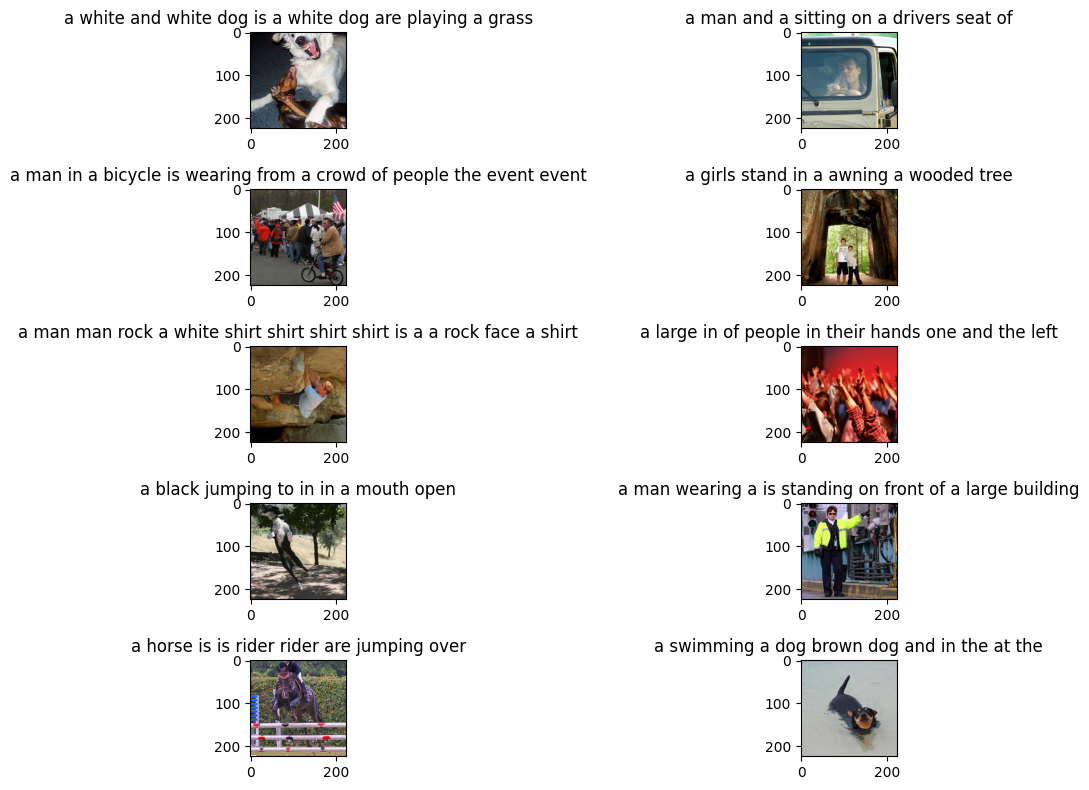

In [69]:
from matplotlib.pyplot import plt
def display_img_caption(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    plt.imshow(img)

    if title is not None:
        plt.title(title)

model.eval()
with torch.no_grad():
    for batch in testloader:
        img, cap = batch
        outs, _ = model(img, cap)
        preds = outs.argmax(dim=2)

        break

    # Create subplots for each image
    num_images = 10
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        plt.subplot(5, 2, i + 1)  # 5 rows, 2 columns
        pred_caption = reverse_numericalize(preds[i], vocab)
        pred_caption = ' '.join(pred_caption)
        display_img_caption(img[i].detach().cpu(), pred_caption)

    plt.tight_layout()
    plt.show()